# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy, Larry Liu

### Task: Predict which block is coming next in an Abstract Syntax Tree (AST), and use the learned hidden representation as an embedding for this AST. This embedding can then be used for predicting the next AST.

Input: For each of the N students, we have a time series of blocks from an AST. 

- input shape (num_asts, num_timesteps, num_blocks)
    - num_timesteps is the max sequence length of blocks that we are taking into account.
    - num_blocks is the total number of blocks that appear in an HOC problem.

Output: At each timestep, we are predicting the next block.
- Output shape (num_asts, num_timesteps, num_blocks). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_asts, num_timesteps) Values are in range (0, num_blocks)


In [50]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Import our own modules
import utils
import model_predict_block as model
import visualize
from constants import *

In [4]:
# hyperparameters
hidden_size = 128 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 8
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [14]:
HOC_NUM = 7
DATA_SZ = -1
train_data, val_data, test_data, all_data, num_timesteps, num_blocks  =\
utils.load_dataset_predict_block(hoc_num=HOC_NUM, data_sz=DATA_SZ)

print 'num_timesteps {}'.format(num_timesteps)

X_train, mask_train, y_train = train_data
X_val, mask_val, y_val = val_data
X_test, mask_test, y_test = test_data
print 'X_train shape {}'.format(X_train.shape)
print 'mask_train shape {}'.format(mask_train.shape)
print 'y_train shape {}'.format(y_train.shape)
print 'X_val shape {}'.format(X_val.shape)
print 'X_test shape {}'.format(X_test.shape)
print X_train[:10,:15:]
print mask_train[:10,:15]
print y_train[:10]

print utils.convert_to_block_strings(y_train[:10])


Preparing network inputs and targets, and the block maps...
Trajectory matrix shape (5926, 20, 15)
Inputs and targets done!
num_timesteps 19
X_train shape (5185, 19, 15)
mask_train shape (5185, 19)
y_train shape (5185, 19)
X_val shape (370, 19, 15)
X_test shape (371, 19, 15)
[[[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]]

 [[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.

In [88]:
# create model
print num_blocks
train_loss_acc, compute_loss_acc, probs, generate_hidden_reps, compute_pred = model.create_model(num_timesteps, num_blocks, hidden_size, learning_rate, \
                                                             grad_clip, dropout_p, num_lstm_layers)

6
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


In [89]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc,\
                                                              compute_pred, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training :)...
Total training iterations: 504
Ep 0 	iter 1  	loss 1.79028, train acc 20.72, train corr acc 16.72, val acc 49.26, val corr acc 1.20
Ep 0 	iter 2  	loss 1.74787, train acc 51.48, train corr acc 0.67, val acc 48.68, val corr acc 0.07
Ep 0 	iter 3  	loss 1.62221, train acc 48.36, train corr acc 0.00, val acc 48.64, val corr acc 0.00
Ep 0 	iter 4  	loss 1.41561, train acc 48.52, train corr acc 0.00, val acc 48.64, val corr acc 0.00
Ep 0 	iter 5  	loss 1.64868, train acc 44.57, train corr acc 0.00, val acc 48.64, val corr acc 0.00
Ep 0 	iter 6  	loss 1.40385, train acc 47.53, train corr acc 0.00, val acc 50.34, val corr acc 3.32
Ep 0 	iter 7  	loss 1.26705, train acc 56.74, train corr acc 2.59, val acc 52.23, val corr acc 7.00
Ep 0 	iter 8  	loss 1.29537, train acc 58.06, train corr acc 8.60, val acc 52.60, val corr acc 7.70
Ep 0 	iter 9  	loss 1.39847, train acc 50.99, train corr acc 10.24, val acc 52.89, val corr acc 8.27
Ep 0 	iter 10  	loss 1.33388, train acc 53.

In [91]:
# Evaluate on test set
test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test')

Testing...
Final results:
  test loss:			1.068040
  test raw accuracy:		61.09 %
  test corrected accuracy:	27.75 %


In [93]:
X_all, mask_all, _ = all_data
ast_embeddings = generate_hidden_reps(X_all, mask_all)

In [94]:
print ast_embeddings.shape
print X_all.shape

(2314, 256)
(2314, 19, 6)


In [95]:
print ast_embeddings[:10, :10]

[[-0.09564256  0.12010601 -0.14471232  0.03233207  0.0092966  -0.30389927
  -0.00350801 -0.28258349 -0.56213086  0.1975325 ]
 [-0.00952602  0.09160703 -0.12065622  0.12200775  0.00967831 -0.24530033
   0.05101336 -0.25496152 -0.07230631  0.43806564]
 [-0.25903327  0.13675017 -0.3137715   0.23230389  0.00969295 -0.48429453
   0.00064772 -0.13579737 -0.37562295  0.036104  ]
 [-0.24501731  0.06020714 -0.146662    0.20097479  0.00366048 -0.40478106
   0.004316   -0.14788355 -0.2099546   0.04359592]
 [-0.09496466  0.08787513 -0.11709445  0.04719868  0.00596931 -0.33923934
   0.00067602 -0.29179712 -0.52984889  0.29522163]
 [-0.02865978  0.05928655 -0.06830794  0.149172    0.00331502 -0.18569762
   0.00573558 -0.28611373 -0.28784729  0.49670875]
 [-0.07915447  0.10210764 -0.19332581  0.27701947  0.00764762 -0.3643594
  -0.02953888 -0.34072351 -0.18025459  0.0696902 ]
 [-0.08949476  0.1555579  -0.23392714  0.30810338  0.01202019 -0.35497929
  -0.04341698 -0.34705117 -0.3045248   0.04484843]
 

In [96]:
utils.save_ast_embeddings(ast_embeddings, HOC_NUM)

In [ ]:
ast_embeddings_ast_row_to_ast_id_map = pickle.load('map_row_index_to_ast_id_2.pickle')
traj_mat_ast_row_to_ast_id_map = pickle.load()

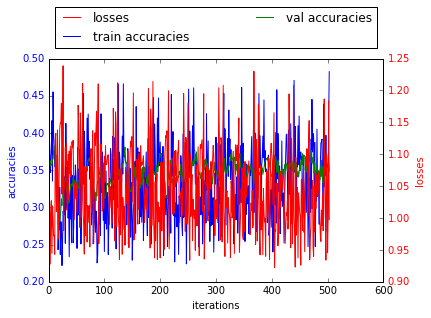

In [72]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = train_data[0].shape[0]
visualize.plot_loss_acc('hoc' + str(HOC_NUM) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')

## Experiment: 
Is it possible to train a single model to create embeddings for programs across all Hocs?

In [23]:
# prepare data for all HOCs
X_all_hocs_mat, mask_all_hocs_mat, y_all_hocs_mat, split_indices = utils.load_dataset_predict_block_all_hocs()
# Shuffle
X_all_hocs_mat, mask_all_hocs_mat, y_all_hocs_mat = shuffle(X_all_hocs_mat, mask_all_hocs_mat, y_all_hocs_mat, random_state=0)

Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
(99950, 19, 8)


In [36]:
print X_all_hocs_mat.shape
print mask_all_hocs_mat.shape
print y_all_hocs_mat.shape
num_samples_total, num_timesteps, num_blocks = X_all_hocs_mat.shape

(99950, 19, 8)
(99950, 19)
(99950, 19)


In [ ]:
# trying out sklearn kfold

In [26]:
kf = KFold(num_samples_total, n_folds=6)
print(kf)  

sklearn.cross_validation.KFold(n=99950, n_folds=6, shuffle=False, random_state=None)


In [37]:
# hyperparameters
hidden_size = 128 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 8
num_epochs = 1
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [31]:
train_loss_acc, compute_loss_acc, probs, generate_hidden_reps, compute_pred = model.create_model(num_timesteps, num_blocks, hidden_size, learning_rate, \
                                                             grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


/Users/lisa1010/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [38]:
# Training!
for train_index, val_index in kf:
    print("TRAIN:", train_index, "TEST:", val_index)
    train_data = (X_all_hocs_mat[train_index], mask_all_hocs_mat[train_index],y_all_hocs_mat[train_index])
    val_data = (X_all_hocs_mat[val_index], mask_all_hocs_mat[val_index],y_all_hocs_mat[val_index])
    
    train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc,\
                                                                  compute_pred, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

('TRAIN:', array([16659, 16660, 16661, ..., 99947, 99948, 99949]), 'TEST:', array([    0,     1,     2, ..., 16656, 16657, 16658]))
Starting training :)...
Total training iterations: 10411
Ep 0 	iter 1  	loss 1.98693, train acc 36.84, train corr acc 2.04, val acc 45.52, val corr acc 6.10
Ep 0 	iter 2  	loss 1.99642, train acc 42.76, train corr acc 8.51, val acc 46.69, val corr acc 8.78
Ep 0 	iter 3  	loss 1.69416, train acc 46.05, train corr acc 7.87, val acc 47.24, val corr acc 11.46
Ep 0 	iter 4  	loss 1.73230, train acc 42.76, train corr acc 7.45, val acc 39.99, val corr acc 12.58
Ep 0 	iter 5  	loss 1.75391, train acc 37.50, train corr acc 12.84, val acc 23.49, val corr acc 9.00
Ep 0 	iter 6  	loss 2.41399, train acc 7.89, train corr acc 2.97, val acc 46.98, val corr acc 13.61
Ep 0 	iter 7  	loss 1.59824, train acc 48.68, train corr acc 12.36, val acc 47.56, val corr acc 10.17
Ep 0 	iter 8  	loss 1.59321, train acc 44.74, train corr acc 11.58, val acc 47.48, val corr acc 9.46
Ep 0 

KeyboardInterrupt: 

In [39]:
X_all_hocs_mat, mask_all_hocs_mat, y_all_hocs_mat, split_indices = utils.load_dataset_predict_block_all_hocs()

Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...


In [40]:
ast_embeddings_all_hocs = generate_hidden_reps(X_all_hocs_mat, mask_all_hocs_mat)

In [42]:
utils.save_ast_embeddings_for_all_hocs(ast_embeddings_all_hocs, split_indices)

In [43]:
print ast_embeddings_all_hocs.shape

(99950, 256)


In [44]:
print ast_embeddings_all_hocs[:10, :10]

[[-0.24856442  0.10019749 -0.0796252  -0.15180447  0.17074073  0.02689021
  -0.37280924 -0.00674305  0.1848056   0.23062699]
 [-0.26208442  0.12359322 -0.1123555  -0.0350733   0.38807956  0.01827913
  -0.21843464 -0.00298318  0.13060198  0.20982095]
 [-0.16009985  0.09530191 -0.0996798  -0.00805891  0.36616792  0.00974815
  -0.17657568 -0.00148262  0.13147062  0.17863403]
 [-0.20231345  0.10337988 -0.17679867  0.05752091  0.34736497 -0.00959668
  -0.1904667  -0.00090355  0.12189703  0.1582936 ]
 [-0.2328481   0.06610216  0.00269448  0.12086811  0.42449915  0.03474641
  -0.12188486 -0.0046818   0.08928466  0.17146715]
 [-0.25416435  0.13397439 -0.17267386  0.01881143  0.40407     0.01572802
  -0.30246928 -0.00157162  0.17562135  0.18961318]
 [-0.18529212  0.04885819 -0.06132809  0.10952254  0.42513228  0.03436801
  -0.09217294 -0.00175755  0.10920363  0.12910401]
 [-0.2649687   0.18198574 -0.06355394 -0.03889779  0.25625495  0.03025404
  -0.26337129 -0.00298908  0.12798115  0.23181765]


In [45]:
 # Optionally, you could now dump the network weights to a file like this:
np.savez('../saved_models/embedding_model_for_all_hocs.npz', lasagne.layers.get_all_param_values(l_out))

# And load them again later on like this:

# with np.load('../saved_models/embedding_model_for_all_hocs.npz') as f:
#     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
#     lasagne.layers.set_all_param_values(l_out, param_values)


AttributeError: 'module' object has no attribute 'get_params'

In [ ]:
# Create embeddings for individual hocs

In [73]:
# hyperparameters
hidden_size = 128 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 4
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [88]:
def create_embedding(hoc_num, use_forward_and_backward_lstm=False, description='indiv'):
    train_data, val_data, test_data, all_data, num_timesteps, num_blocks  =\
    utils.load_dataset_predict_block(hoc_num)

    X_train, mask_train, y_train = train_data
    X_val, mask_val, y_val = val_data
    X_test, mask_test, y_test = test_data
    
    train_loss_acc, compute_loss_acc, probs, generate_hidden_reps, compute_pred,l_out = model.create_model(num_timesteps, num_blocks, hidden_size, learning_rate, \
                                                             grad_clip, dropout_p, num_lstm_layers, use_forward_and_backward_lstm=use_forward_and_backward_lstm)
    train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc,\
                                                              compute_pred, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)
    test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test')
    
    # Visualize the loss and the accuracies for both training and validation sets for each epoch
    num_train = train_data[0].shape[0]
    visualize.plot_loss_acc('hoc' + str(HOC_NUM) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')
    
    X_all, mask_all, _ = all_data
    ast_embeddings = generate_hidden_reps(X_all, mask_all)
    utils.save_ast_embeddings(ast_embeddings, hoc_num, description=description)
    np.savez('../saved_models/indiv_embedding_model_' + str(hoc_num) + '.npz', lasagne.layers.get_all_param_values(l_out))

Preparing network inputs and targets, and the block maps for hoc 1
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 420
Ep 0 	iter 1  	loss 2.08002, train acc 9.87, train corr acc 16.15, val acc 67.30, val corr acc 38.65
Ep 0 	iter 2  	loss 1.99513, train acc 73.03, train corr acc 45.87, val acc 62.07, val corr acc 28.47
Ep 0 	iter 3  	loss 1.77609, train acc 67.60, train corr acc 30.39, val acc 59.93, val corr acc 24.44
Ep 0 	iter 4  	loss 1.20975, train acc 68.26, train corr acc 30.82, val acc 59.57, val corr acc 23.76
Ep 0 	iter 5  	loss 1.19006, train acc 64.14, train corr acc 29.90, val acc 61.61, val corr acc 27.61
Ep 0 	iter 6  	loss 1.11191, train acc 61.18, train corr acc 29.13, val acc 62.50, val corr acc 29.28
Ep 0 	iter 7  	loss 0.84455, train acc 63.82, train corr acc 28.80, val acc 61.55, val corr acc 27.48
Ep 0 	iter 8  	loss 0.84550, train acc 62.83, train corr acc 28.25, val acc 63.09, 

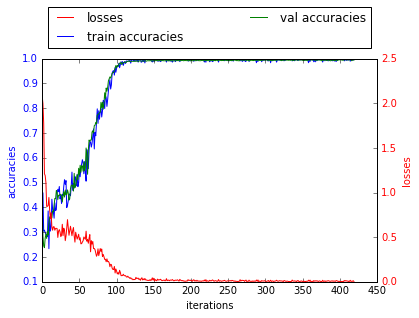

Preparing network inputs and targets, and the block maps for hoc 2
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 378
Ep 0 	iter 1  	loss 2.08276, train acc 4.61, train corr acc 5.59, val acc 75.39, val corr acc 52.88
Ep 0 	iter 2  	loss 2.00560, train acc 76.64, train corr acc 53.47, val acc 69.87, val corr acc 41.71
Ep 0 	iter 3  	loss 1.80001, train acc 67.76, train corr acc 37.58, val acc 63.27, val corr acc 28.93
Ep 0 	iter 4  	loss 1.29929, train acc 64.97, train corr acc 29.70, val acc 60.87, val corr acc 24.30
Ep 0 	iter 5  	loss 1.11380, train acc 63.32, train corr acc 27.36, val acc 60.51, val corr acc 23.60
Ep 0 	iter 6  	loss 0.94589, train acc 65.46, train corr acc 29.29, val acc 65.84, val corr acc 33.92
Ep 0 	iter 7  	loss 0.90505, train acc 61.35, train corr acc 34.54, val acc 65.55, val corr acc 33.36
Ep 0 	iter 8  	loss 0.83825, train acc 66.12, train corr acc 32.01, val acc 69.66, v

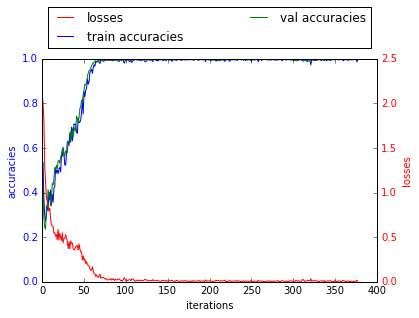

Preparing network inputs and targets, and the block maps for hoc 3
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 636
Ep 0 	iter 1  	loss 2.08124, train acc 5.59, train corr acc 2.50, val acc 72.58, val corr acc 52.81
Ep 0 	iter 2  	loss 2.01220, train acc 70.39, train corr acc 45.40, val acc 74.14, val corr acc 50.84
Ep 0 	iter 3  	loss 1.79888, train acc 72.70, train corr acc 49.08, val acc 66.50, val corr acc 36.33
Ep 0 	iter 4  	loss 1.37707, train acc 62.34, train corr acc 37.43, val acc 62.58, val corr acc 28.86
Ep 0 	iter 5  	loss 1.25545, train acc 57.57, train corr acc 25.65, val acc 61.07, val corr acc 25.99
Ep 0 	iter 6  	loss 0.96958, train acc 62.66, train corr acc 27.24, val acc 62.70, val corr acc 29.11
Ep 0 	iter 7  	loss 0.91698, train acc 59.38, train corr acc 23.53, val acc 67.43, val corr acc 38.09
Ep 0 	iter 8  	loss 0.88813, train acc 62.66, train corr acc 35.14, val acc 68.53, v

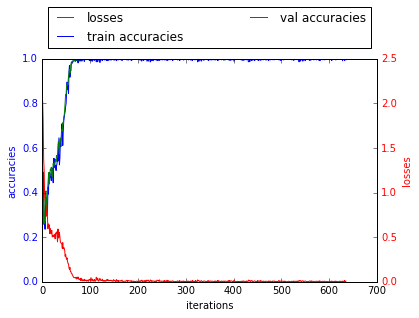

Preparing network inputs and targets, and the block maps for hoc 4
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 594
Ep 0 	iter 1  	loss 2.07865, train acc 13.49, train corr acc 7.99, val acc 67.91, val corr acc 38.15
Ep 0 	iter 2  	loss 1.99178, train acc 68.26, train corr acc 42.22, val acc 63.23, val corr acc 28.97
Ep 0 	iter 3  	loss 1.70227, train acc 64.64, train corr acc 29.28, val acc 60.07, val corr acc 22.88
Ep 0 	iter 4  	loss 1.20065, train acc 61.02, train corr acc 22.30, val acc 58.68, val corr acc 20.20
Ep 0 	iter 5  	loss 1.20775, train acc 55.26, train corr acc 16.31, val acc 61.35, val corr acc 25.35
Ep 0 	iter 6  	loss 0.93097, train acc 63.98, train corr acc 26.26, val acc 64.34, val corr acc 31.12
Ep 0 	iter 7  	loss 0.85285, train acc 63.16, train corr acc 28.43, val acc 65.92, val corr acc 34.17
Ep 0 	iter 8  	loss 0.77834, train acc 68.75, train corr acc 33.10, val acc 67.47, 

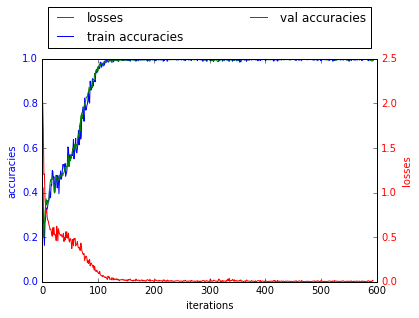

Preparing network inputs and targets, and the block maps for hoc 5
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 2028
Ep 0 	iter 1  	loss 2.08157, train acc 9.21, train corr acc 17.24, val acc 70.99, val corr acc 51.14
Ep 0 	iter 2  	loss 1.99968, train acc 74.01, train corr acc 54.55, val acc 67.15, val corr acc 40.46
Ep 0 	iter 3  	loss 1.77497, train acc 67.27, train corr acc 39.33, val acc 60.82, val corr acc 28.98
Ep 0 	iter 4  	loss 1.25579, train acc 61.02, train corr acc 28.40, val acc 58.94, val corr acc 25.57
Ep 0 	iter 5  	loss 1.09722, train acc 62.83, train corr acc 30.25, val acc 60.65, val corr acc 28.66
Ep 0 	iter 6  	loss 0.96606, train acc 59.05, train corr acc 22.91, val acc 62.07, val corr acc 31.24
Ep 0 	iter 7  	loss 0.91741, train acc 56.91, train corr acc 29.76, val acc 65.60, val corr acc 37.63
Ep 0 	iter 8  	loss 0.87459, train acc 64.31, train corr acc 38.53, val acc 64.93,

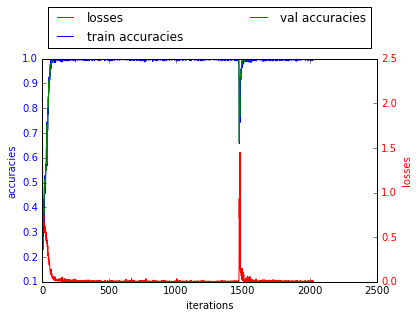

Preparing network inputs and targets, and the block maps for hoc 6
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 402
Ep 0 	iter 1  	loss 2.07994, train acc 9.21, train corr acc 15.08, val acc 70.61, val corr acc 45.59
Ep 0 	iter 2  	loss 2.01616, train acc 67.60, train corr acc 38.22, val acc 71.70, val corr acc 44.65
Ep 0 	iter 3  	loss 1.85990, train acc 70.39, train corr acc 34.78, val acc 67.02, val corr acc 35.49
Ep 0 	iter 4  	loss 1.55605, train acc 60.53, train corr acc 31.03, val acc 64.63, val corr acc 30.82
Ep 0 	iter 5  	loss 1.30243, train acc 63.49, train corr acc 24.23, val acc 62.88, val corr acc 27.41
Ep 0 	iter 6  	loss 1.33291, train acc 52.63, train corr acc 13.51, val acc 60.80, val corr acc 23.33
Ep 0 	iter 7  	loss 1.06884, train acc 65.30, train corr acc 26.99, val acc 68.42, val corr acc 38.24
Ep 0 	iter 8  	loss 0.94057, train acc 72.86, train corr acc 37.97, val acc 69.28, 

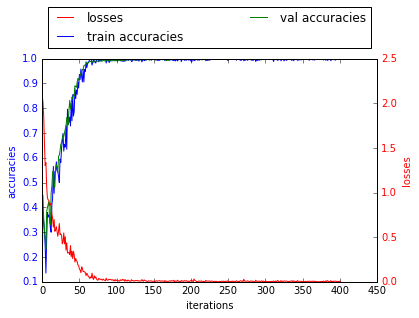

Preparing network inputs and targets, and the block maps for hoc 7
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 972
Ep 0 	iter 1  	loss 2.07806, train acc 14.31, train corr acc 10.40, val acc 68.41, val corr acc 36.06
Ep 0 	iter 2  	loss 1.98855, train acc 73.19, train corr acc 46.56, val acc 64.86, val corr acc 28.63
Ep 0 	iter 3  	loss 1.79990, train acc 63.32, train corr acc 26.40, val acc 61.39, val corr acc 21.58
Ep 0 	iter 4  	loss 1.34862, train acc 59.87, train corr acc 21.29, val acc 58.62, val corr acc 15.95
Ep 0 	iter 5  	loss 1.22454, train acc 62.66, train corr acc 22.79, val acc 62.82, val corr acc 24.47
Ep 0 	iter 6  	loss 1.28454, train acc 58.72, train corr acc 21.07, val acc 65.60, val corr acc 30.14
Ep 0 	iter 7  	loss 1.10532, train acc 63.32, train corr acc 34.22, val acc 66.87, val corr acc 32.71
Ep 0 	iter 8  	loss 1.02217, train acc 64.31, train corr acc 32.61, val acc 68.31,

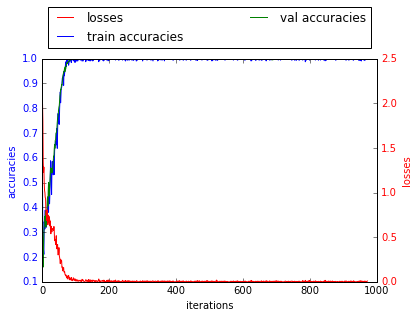

Preparing network inputs and targets, and the block maps for hoc 8
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 2700
Ep 0 	iter 1  	loss 2.08121, train acc 7.24, train corr acc 12.78, val acc 65.73, val corr acc 38.34
Ep 0 	iter 2  	loss 2.01062, train acc 62.34, train corr acc 38.44, val acc 64.26, val corr acc 35.69
Ep 0 	iter 3  	loss 1.83138, train acc 59.38, train corr acc 32.51, val acc 61.17, val corr acc 30.12
Ep 0 	iter 4  	loss 1.42859, train acc 60.86, train corr acc 28.10, val acc 58.53, val corr acc 25.39
Ep 0 	iter 5  	loss 1.35532, train acc 60.03, train corr acc 25.00, val acc 60.45, val corr acc 28.84
Ep 0 	iter 6  	loss 1.20048, train acc 60.86, train corr acc 33.33, val acc 62.53, val corr acc 32.58
Ep 0 	iter 7  	loss 1.12020, train acc 61.02, train corr acc 30.09, val acc 62.81, val corr acc 33.08
Ep 0 	iter 8  	loss 1.09402, train acc 61.35, train corr acc 31.29, val acc 64.90,

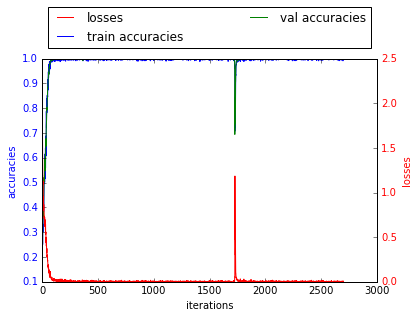

Preparing network inputs and targets, and the block maps for hoc 9
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 8250
Ep 0 	iter 1  	loss 2.08147, train acc 7.40, train corr acc 7.96, val acc 61.60, val corr acc 37.87
Ep 0 	iter 2  	loss 2.02386, train acc 64.47, train corr acc 40.00, val acc 57.71, val corr acc 31.56
Ep 0 	iter 3  	loss 1.88295, train acc 58.22, train corr acc 29.44, val acc 52.01, val corr acc 22.34
Ep 0 	iter 4  	loss 1.50610, train acc 51.15, train corr acc 20.80, val acc 50.37, val corr acc 19.70
Ep 0 	iter 5  	loss 1.46889, train acc 53.78, train corr acc 21.07, val acc 52.78, val corr acc 23.58
Ep 0 	iter 6  	loss 1.29559, train acc 53.12, train corr acc 23.59, val acc 52.63, val corr acc 23.35
Ep 0 	iter 7  	loss 1.26147, train acc 50.66, train corr acc 23.47, val acc 56.96, val corr acc 30.36
Ep 0 	iter 8  	loss 1.21969, train acc 55.92, train corr acc 29.10, val acc 59.10, 

KeyboardInterrupt: 

In [86]:
for hoc_num in xrange(HOC_MIN, HOC_MAX + 1):
    create_embedding(hoc_num, use_forward_and_backward_lstm=True)


Preparing network inputs and targets, and the block maps for hoc 1
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 420
Ep 0 	iter 1  	loss 2.07999, train acc 10.53, train corr acc 12.78, val acc 51.38, val corr acc 11.60
Ep 0 	iter 2  	loss 2.03588, train acc 52.96, train corr acc 10.62, val acc 51.09, val corr acc 8.21
Ep 0 	iter 3  	loss 1.90252, train acc 50.16, train corr acc 8.18, val acc 48.95, val corr acc 4.20
Ep 0 	iter 4  	loss 1.58579, train acc 51.64, train corr acc 5.47, val acc 46.78, val corr acc 0.12
Ep 0 	iter 5  	loss 1.55471, train acc 44.74, train corr acc 0.00, val acc 46.78, val corr acc 0.12
Ep 0 	iter 6  	loss 1.50573, train acc 44.90, train corr acc 0.30, val acc 48.88, val corr acc 4.07
Ep 0 	iter 7  	loss 1.37496, train acc 50.49, train corr acc 4.14, val acc 50.72, val corr acc 7.53
Ep 0 	iter 8  	loss 1.45943, train acc 46.05, train corr acc 7.10, val acc 51.32, val corr ac

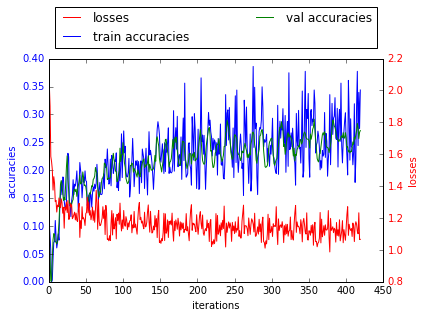

Preparing network inputs and targets, and the block maps for hoc 2
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 378
Ep 0 	iter 1  	loss 2.08245, train acc 9.54, train corr acc 17.07, val acc 48.46, val corr acc 13.75
Ep 0 	iter 2  	loss 2.03495, train acc 47.86, train corr acc 9.03, val acc 50.09, val corr acc 7.35
Ep 0 	iter 3  	loss 1.91978, train acc 49.01, train corr acc 7.46, val acc 48.49, val corr acc 4.38
Ep 0 	iter 4  	loss 1.58604, train acc 49.01, train corr acc 4.91, val acc 46.28, val corr acc 0.27
Ep 0 	iter 5  	loss 1.38450, train acc 51.81, train corr acc 0.00, val acc 46.28, val corr acc 0.27
Ep 0 	iter 6  	loss 1.50103, train acc 49.51, train corr acc 0.00, val acc 46.32, val corr acc 0.34
Ep 0 	iter 7  	loss 1.41595, train acc 49.51, train corr acc 0.32, val acc 47.22, val corr acc 2.16
Ep 0 	iter 8  	loss 1.38290, train acc 48.03, train corr acc 3.07, val acc 49.87, val corr acc 

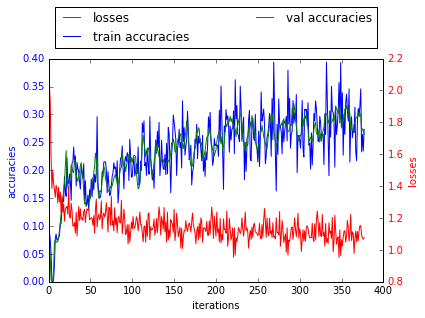

Preparing network inputs and targets, and the block maps for hoc 3
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 636
Ep 0 	iter 1  	loss 2.08077, train acc 11.02, train corr acc 19.35, val acc 52.74, val corr acc 16.79
Ep 0 	iter 2  	loss 2.03607, train acc 54.11, train corr acc 18.01, val acc 52.59, val corr acc 12.36
Ep 0 	iter 3  	loss 1.90889, train acc 54.61, train corr acc 16.11, val acc 51.81, val corr acc 10.93
Ep 0 	iter 4  	loss 1.61876, train acc 53.12, train corr acc 12.31, val acc 49.59, val corr acc 6.82
Ep 0 	iter 5  	loss 1.49158, train acc 52.63, train corr acc 8.57, val acc 49.59, val corr acc 6.82
Ep 0 	iter 6  	loss 1.56877, train acc 46.71, train corr acc 7.16, val acc 50.73, val corr acc 8.93
Ep 0 	iter 7  	loss 1.50436, train acc 46.55, train corr acc 8.71, val acc 52.80, val corr acc 12.96
Ep 0 	iter 8  	loss 1.39141, train acc 55.59, train corr acc 14.60, val acc 52.91, val c

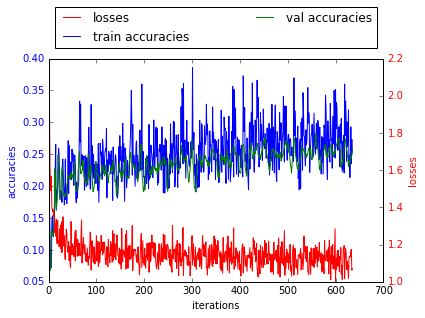

Preparing network inputs and targets, and the block maps for hoc 4
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 594
Ep 0 	iter 1  	loss 2.08057, train acc 7.07, train corr acc 8.28, val acc 49.66, val corr acc 8.09
Ep 0 	iter 2  	loss 2.03346, train acc 55.76, train corr acc 8.50, val acc 49.39, val corr acc 7.54
Ep 0 	iter 3  	loss 1.92645, train acc 51.15, train corr acc 8.05, val acc 49.18, val corr acc 7.16
Ep 0 	iter 4  	loss 1.57130, train acc 54.77, train corr acc 7.09, val acc 48.90, val corr acc 6.65
Ep 0 	iter 5  	loss 1.49961, train acc 52.30, train corr acc 7.05, val acc 49.13, val corr acc 7.07
Ep 0 	iter 6  	loss 1.50242, train acc 51.48, train corr acc 7.52, val acc 49.41, val corr acc 7.58
Ep 0 	iter 7  	loss 1.44187, train acc 47.53, train corr acc 7.54, val acc 50.03, val corr acc 11.31
Ep 0 	iter 8  	loss 1.41609, train acc 55.43, train corr acc 12.79, val acc 50.99, val corr acc 

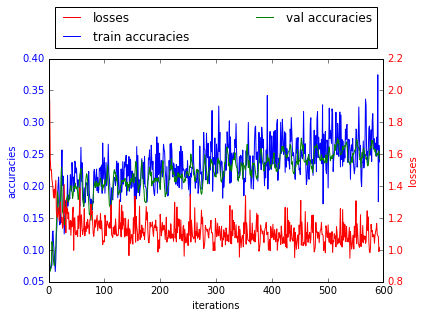

Preparing network inputs and targets, and the block maps for hoc 5
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 2028
Ep 0 	iter 1  	loss 2.07702, train acc 19.08, train corr acc 10.61, val acc 48.68, val corr acc 8.36
Ep 0 	iter 2  	loss 2.01494, train acc 47.53, train corr acc 8.09, val acc 48.51, val corr acc 6.49
Ep 0 	iter 3  	loss 1.76726, train acc 52.47, train corr acc 7.37, val acc 45.54, val corr acc 1.06
Ep 0 	iter 4  	loss 1.60606, train acc 39.80, train corr acc 0.27, val acc 45.05, val corr acc 0.16
Ep 0 	iter 5  	loss 1.54421, train acc 43.75, train corr acc 0.00, val acc 45.50, val corr acc 0.98
Ep 0 	iter 6  	loss 1.44919, train acc 43.59, train corr acc 0.29, val acc 47.45, val corr acc 4.53
Ep 0 	iter 7  	loss 1.47797, train acc 40.79, train corr acc 4.26, val acc 49.44, val corr acc 8.15
Ep 0 	iter 8  	loss 1.41128, train acc 53.12, train corr acc 9.81, val acc 49.85, val corr acc

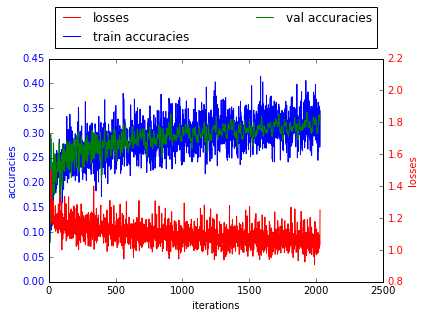

Preparing network inputs and targets, and the block maps for hoc 6
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 402
Ep 0 	iter 1  	loss 2.08090, train acc 6.09, train corr acc 8.33, val acc 56.05, val corr acc 11.96
Ep 0 	iter 2  	loss 2.03072, train acc 54.11, train corr acc 11.44, val acc 55.98, val corr acc 9.36
Ep 0 	iter 3  	loss 1.90660, train acc 55.43, train corr acc 9.36, val acc 53.49, val corr acc 4.22
Ep 0 	iter 4  	loss 1.56725, train acc 54.11, train corr acc 4.45, val acc 51.54, val corr acc 0.21
Ep 0 	iter 5  	loss 1.66354, train acc 49.67, train corr acc 0.33, val acc 52.05, val corr acc 1.27
Ep 0 	iter 6  	loss 1.86698, train acc 46.05, train corr acc 1.80, val acc 53.66, val corr acc 4.57
Ep 0 	iter 7  	loss 1.40643, train acc 56.41, train corr acc 4.69, val acc 54.10, val corr acc 5.49
Ep 0 	iter 8  	loss 1.43405, train acc 54.77, train corr acc 6.46, val acc 54.78, val corr acc 

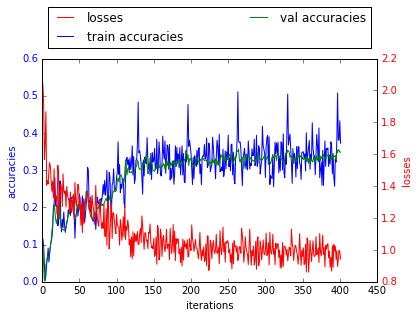

Preparing network inputs and targets, and the block maps for hoc 7
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 972
Ep 0 	iter 1  	loss 2.08009, train acc 12.17, train corr acc 16.72, val acc 53.53, val corr acc 5.45
Ep 0 	iter 2  	loss 2.03349, train acc 48.68, train corr acc 3.11, val acc 52.32, val corr acc 2.87
Ep 0 	iter 3  	loss 1.89743, train acc 53.62, train corr acc 2.76, val acc 51.25, val corr acc 0.70
Ep 0 	iter 4  	loss 1.56531, train acc 51.97, train corr acc 0.34, val acc 50.94, val corr acc 0.06
Ep 0 	iter 5  	loss 1.61161, train acc 50.66, train corr acc 0.00, val acc 50.94, val corr acc 0.06
Ep 0 	iter 6  	loss 1.31846, train acc 57.24, train corr acc 0.00, val acc 51.00, val corr acc 0.17
Ep 0 	iter 7  	loss 1.47442, train acc 50.33, train corr acc 0.00, val acc 51.76, val corr acc 1.74
Ep 0 	iter 8  	loss 1.42175, train acc 49.67, train corr acc 1.29, val acc 53.16, val corr acc 

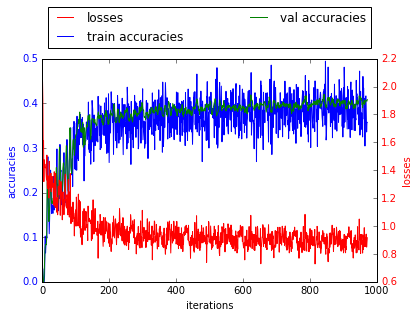

Preparing network inputs and targets, and the block maps for hoc 8
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 2700
Ep 0 	iter 1  	loss 2.08115, train acc 9.21, train corr acc 13.69, val acc 52.51, val corr acc 21.51
Ep 0 	iter 2  	loss 2.03715, train acc 54.77, train corr acc 23.87, val acc 51.56, val corr acc 13.62
Ep 0 	iter 3  	loss 1.92846, train acc 53.12, train corr acc 13.41, val acc 49.18, val corr acc 9.29
Ep 0 	iter 4  	loss 1.65316, train acc 46.05, train corr acc 10.50, val acc 45.13, val corr acc 2.05
Ep 0 	iter 5  	loss 1.74831, train acc 45.56, train corr acc 2.36, val acc 47.76, val corr acc 6.75
Ep 0 	iter 6  	loss 1.60165, train acc 49.01, train corr acc 9.62, val acc 50.76, val corr acc 12.10
Ep 0 	iter 7  	loss 1.41794, train acc 55.26, train corr acc 12.82, val acc 51.73, val corr acc 13.84
Ep 0 	iter 8  	loss 1.50887, train acc 50.66, train corr acc 14.77, val acc 52.71, val 

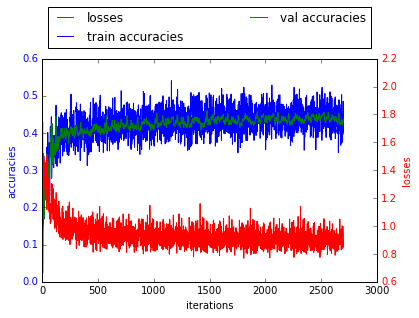

Preparing network inputs and targets, and the block maps for hoc 9
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training :...
Total training iterations: 8250
Ep 0 	iter 1  	loss 2.07927, train acc 9.21, train corr acc 11.92, val acc 44.68, val corr acc 11.03
Ep 0 	iter 2  	loss 2.04084, train acc 45.07, train corr acc 10.75, val acc 42.98, val corr acc 7.88
Ep 0 	iter 3  	loss 1.92618, train acc 42.93, train corr acc 6.72, val acc 41.20, val corr acc 4.96
Ep 0 	iter 4  	loss 1.57961, train acc 46.88, train corr acc 5.83, val acc 38.19, val corr acc 0.09
Ep 0 	iter 5  	loss 2.05972, train acc 36.35, train corr acc 0.00, val acc 39.30, val corr acc 1.87
Ep 0 	iter 6  	loss 1.82972, train acc 38.32, train corr acc 2.34, val acc 42.59, val corr acc 7.25
Ep 0 	iter 7  	loss 1.65090, train acc 40.79, train corr acc 6.49, val acc 44.46, val corr acc 10.56
Ep 0 	iter 8  	loss 1.68643, train acc 42.76, train corr acc 10.10, val acc 46.07, val corr 

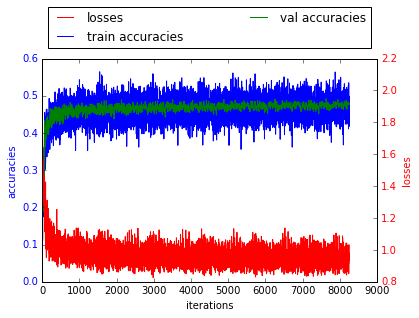

In [ ]:
for hoc_num in xrange(HOC_MIN, HOC_MAX + 1):
    create_embedding(hoc_num, use_forward_and_backward_lstm=False, description='only_forward')